<a href="https://colab.research.google.com/github/5EBIN/Ensemble-Learning-for-Pneumonia-Detection/blob/main/ML_prj_pneumonia_detect_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q kaggle tensorflow keras opencv-python scikit-learn matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score


from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/chest_xray"  # adjust to your path


img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


classes = np.unique(train_generator.classes)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


def build_model(base_model_class, name):
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=(img_size,img_size,3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    out = Dense(1, activation="sigmoid")(x)
    model = Model(base_model.input, out, name=name)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    return model


models = {
    "MobileNetV2": build_model(MobileNetV2, "MobileNetV2"),
    "ResNet50": build_model(ResNet50, "ResNet50"),
    "DenseNet121": build_model(DenseNet121, "DenseNet121")
}

history = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    h = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        class_weight=class_weights,
        verbose=1
    )
    history[name] = h


y_probs_list = []
for name, model in models.items():
    y_prob = model.predict(test_generator, verbose=0)
    y_probs_list.append(y_prob)


y_probs = np.mean(y_probs_list, axis=0)


threshold = 0.55
y_pred = (y_probs > threshold).astype(int)


y_true = test_generator.classes
print("\nClassification Report (Ensemble with threshold):")
print(classification_report(y_true, y_pred, target_names=["Normal","Pneumonia"]))
print("ROC-AUC:", roc_auc_score(y_true, y_probs))


save_dir = "/content/drive/MyDrive/chestxrays"
os.makedirs(save_dir, exist_ok=True)
for name, model in models.items():
    save_path = os.path.join(save_dir, f"{name}_saved")
    model.save(save_path)
    print(f"✅ {name} saved to {save_path}")

Mounted at /content/drive
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training MobileNetV2...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 936s 7s/step - accuracy: 0.5548 - loss: 0.6957 - val_accuracy: 0.7795 - val_loss: 0.4937
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 848ms/step - accuracy: 0.7435 - loss: 0.5328 - val_accuracy: 0.8063 - val_loss: 0.4406
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 860ms/step - accuracy: 0.7997 - loss: 0.4312 - val_accuracy: 0.8044 - val_loss: 0.3980
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 111s 851ms/step - accuracy: 0.8379 - loss: 0.3752 - val_accuracy: 0.8552 - val_loss: 0.3515
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 865ms/step - accuracy: 0.8461 - loss: 0.3488 - val_accuracy: 0.8514 - val_loss: 0.3295
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 859ms/step - accuracy: 0.8693 - loss: 0.3038 - val_accuracy: 0.8667 - val_loss: 0.3093
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8818 - loss: 0.2790 - val_accuracy: 0.8849 - val_loss: 0.2880
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 859ms/step - accuracy: 0.8881 - loss:

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/chestxrays/MobileNetV2_saved.

In [ ]:
for name, model in models.items():
    save_path = os.path.join(save_dir, f"{name}_saved.keras")
    model.save(save_path)
    print(f"✅ {name} saved to {save_path}")


✅ MobileNetV2 saved to /content/drive/MyDrive/chestxrays/MobileNetV2_saved.keras
✅ ResNet50 saved to /content/drive/MyDrive/chestxrays/ResNet50_saved.keras
✅ DenseNet121 saved to /content/drive/MyDrive/chestxrays/DenseNet121_saved.keras


In [ ]:
!pip install -q kaggle tensorflow keras opencv-python scikit-learn matplotlib

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score


from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/chest_xray"  # adjust to your path


img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


classes = np.unique(train_generator.classes)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


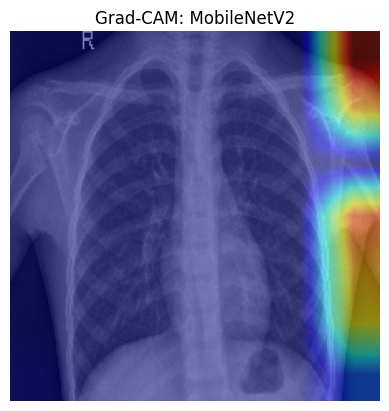

In [ ]:
import cv2

def grad_cam(model, img_array, layer_name):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam[0], (img_size, img_size))
    cam = cam / cam.max()
    return cam

# Pick one test image and visualize
sample_img, _ = next(iter(test_generator))
cam = grad_cam(models["MobileNetV2"], sample_img[0:1], layer_name="Conv_1")

plt.imshow(sample_img[0])
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Grad-CAM: MobileNetV2")
plt.axis("off")
plt.show()

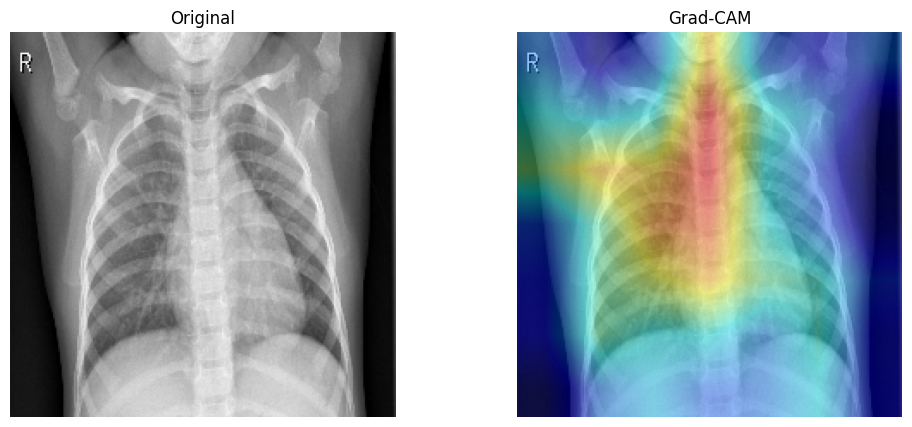

Raw Predictions: tf.Tensor([0.16126029], shape=(1,), dtype=float32)
Predicted Class: 0


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

def get_gradcam(model, img_array, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

    return heatmap, predictions

def overlay_gradcam_from_generator(model, test_generator, layer_name=None):
    sample_img, _ = next(iter(test_generator))
    img_array = np.expand_dims(sample_img[0], axis=0)

    heatmap, predictions = get_gradcam(model, img_array, layer_name)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_bgr = cv2.cvtColor((sample_img[0] * 255).astype("uint8"), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print("Raw Predictions:", predictions[0])
    print("Predicted Class:", np.argmax(predictions[0]))

densenet = load_model("/content/drive/MyDrive/chestxrays/DenseNet121_saved.keras")
overlay_gradcam_from_generator(densenet, test_generator, layer_name="conv5_block16_concat")



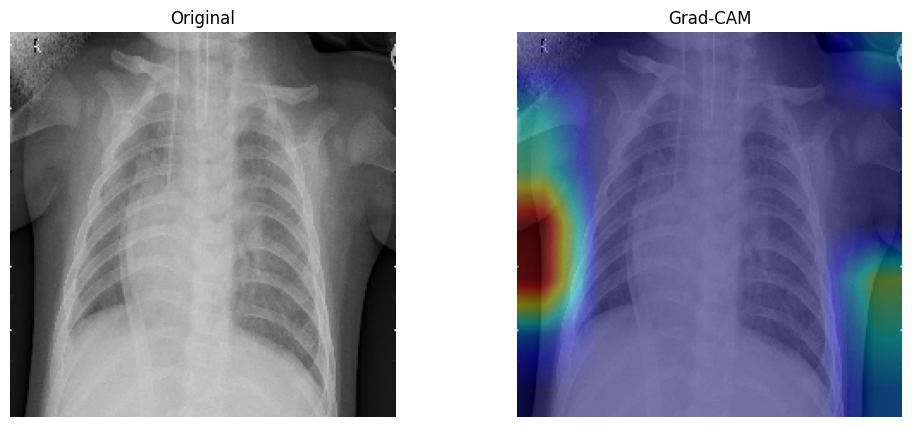

Predictions: {'Normal': 0.8505688905715942}
Predicted Class: Normal


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

CLASS_LABELS = ["Normal", "Pneumonia"]

def get_gradcam(model, img_array, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)

    return heatmap, predictions

def overlay_gradcam_from_generator(model, test_generator, layer_name=None):
    sample_img, _ = next(iter(test_generator))
    img_array = np.expand_dims(sample_img[0], axis=0)

    heatmap, predictions = get_gradcam(model, img_array, layer_name)

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_bgr = cv2.cvtColor((sample_img[0] * 255).astype("uint8"), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    probs = predictions[0].numpy()
    formatted_preds = {label: float(prob) for label, prob in zip(CLASS_LABELS, probs)}

    print("Predictions:", formatted_preds)
    print("Predicted Class:", CLASS_LABELS[np.argmax(probs)])

densenet = load_model("/content/drive/MyDrive/chestxrays/DenseNet121_saved.keras")
overlay_gradcam_from_generator(densenet, test_generator, layer_name="conv5_block16_concat")

Saving person1_virus_7.jpeg to person1_virus_7.jpeg


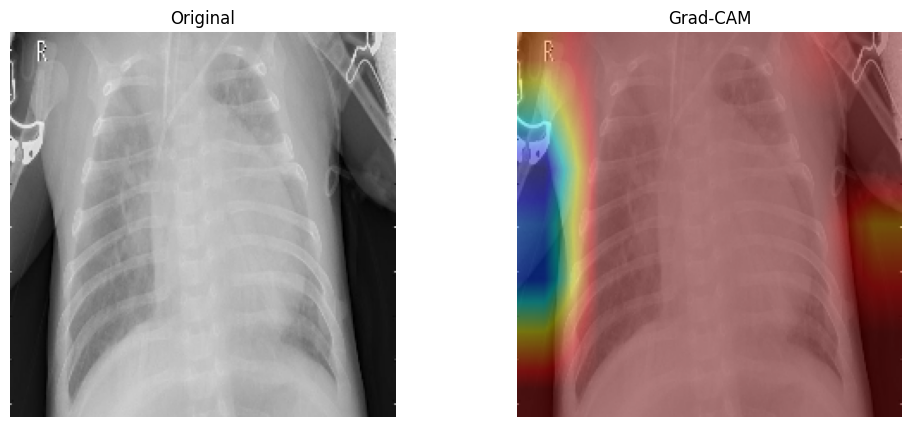

Predictions: {'Normal': '0.96'}
Predicted Class: Normal


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files

CLASS_LABELS = ["Normal", "Pneumonia"]


def preprocess_image(img_path, target_size=(224,224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img_resized


def get_gradcam(model, img_array, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap, predictions


def overlay_gradcam_from_image(model, layer_name=None):
    # Upload image
    uploaded = files.upload()
    img_path = list(uploaded.keys())[0]

    img_array, orig_img = preprocess_image(img_path)
    heatmap, predictions = get_gradcam(model, img_array, layer_name)

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(orig_img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

    probs = predictions[0].numpy()
    formatted_preds = {label: float(prob) for label, prob in zip(CLASS_LABELS, probs)}

    print("Predictions:", {k: f"{v:.2f}" for k,v in formatted_preds.items()})
    print("Predicted Class:", CLASS_LABELS[np.argmax(probs)])


densenet = load_model("/content/drive/MyDrive/chestxrays/DenseNet121_saved.keras")


overlay_gradcam_from_image(densenet, layer_name="conv5_block16_concat")


Saving IM-0011-0001.jpeg to IM-0011-0001 (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
DenseNet121 Pneumonia prob: 0.44
MobileNetV2 Pneumonia prob: 0.04
ResNet50 Pneumonia prob: 0.50

Ensemble Pneumonia prob: 0.22
Ensemble Predicted Class: Normal


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


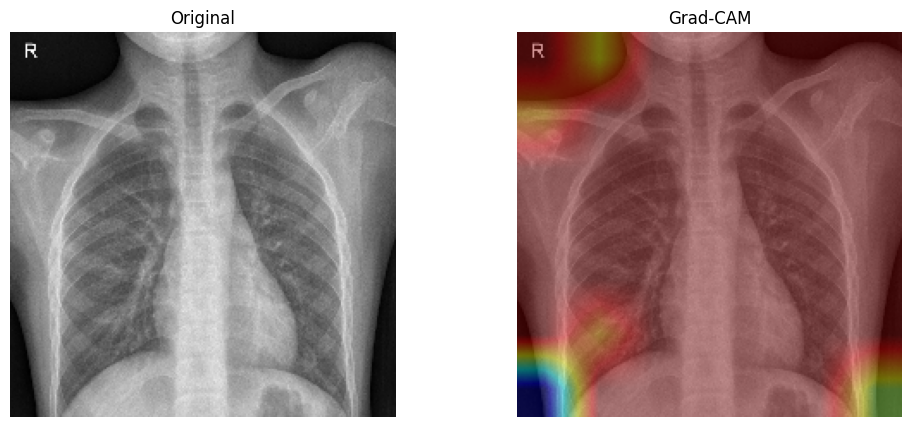

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files

CLASS_LABELS = ["Normal", "Pneumonia"]

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

def preprocess_image(img_path, target_size=(224,224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img_resized

def get_gradcam(model, img_array, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap)+1e-8)
    return heatmap, predictions

def overlay_gradcam(model, img_array, orig_img, layer_name=None):
    heatmap, _ = get_gradcam(model, img_array, layer_name)
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(orig_img)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

densenet = load_model("/content/drive/MyDrive/chestxrays/DenseNet121_saved.keras")
mobilenet = load_model("/content/drive/MyDrive/chestxrays/MobileNetV2_saved.keras")
resnet = load_model("/content/drive/MyDrive/chestxrays/ResNet50_saved.keras")

img_array, orig_img = preprocess_image(img_path)

probs_dense = densenet.predict(img_array)[0][0]
probs_mobilenet = mobilenet.predict(img_array)[0][0]
probs_resnet = resnet.predict(img_array)[0][0]

print(f"DenseNet121 Pneumonia prob: {probs_dense:.2f}")
print(f"MobileNetV2 Pneumonia prob: {probs_mobilenet:.2f}")
print(f"ResNet50 Pneumonia prob: {probs_resnet:.2f}")

weights = [0.45, 0.55, 0]
ensemble_prob = (weights[0]*probs_dense + weights[1]*probs_mobilenet + weights[2]*probs_resnet)
ensemble_class = "Pneumonia" if ensemble_prob>0.5 else "Normal"
print(f"\nEnsemble Pneumonia prob: {ensemble_prob:.2f}")
print(f"Ensemble Predicted Class: {ensemble_class}")

overlay_gradcam(densenet, img_array, orig_img, layer_name="conv5_block16_concat")

Final Inference Cell

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/chest_xray"

Mounted at /content/drive


Saving person1_virus_7.jpeg to person1_virus_7 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
DenseNet121 Pneumonia prob: 0.96
MobileNetV2 Pneumonia prob: 0.99
ResNet50 Pneumonia prob: 0.51

Ensemble Pneumonia prob: 0.95
Ensemble Predicted Class: Pneumonia


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


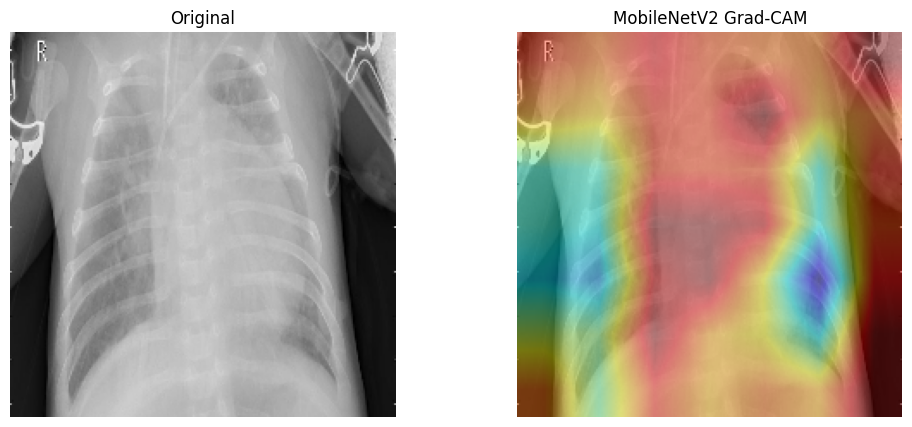

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files

CLASS_LABELS = ["Normal", "Pneumonia"]

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

def preprocess_image(img_path, target_size=(224,224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img_resized

def get_gradcam(model, img_array, layer_name=None):
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap)+1e-8)
    return heatmap, predictions

def overlay_gradcam(model, img_array, orig_img, layer_name=None):
    heatmap, _ = get_gradcam(model, img_array, layer_name)
    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(orig_img)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.title("MobileNetV2 Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

densenet = load_model("/content/drive/MyDrive/chestxrays/DenseNet121_saved.keras")
mobilenet = load_model("/content/drive/MyDrive/chestxrays/MobileNetV2_saved.keras")
resnet = load_model("/content/drive/MyDrive/chestxrays/ResNet50_saved.keras")

img_array, orig_img = preprocess_image(img_path)

probs_dense = densenet.predict(img_array).item()
probs_mobilenet = mobilenet.predict(img_array).item()
probs_resnet = resnet.predict(img_array).item()

print(f"DenseNet121 Pneumonia prob: {probs_dense:.2f}")
print(f"MobileNetV2 Pneumonia prob: {probs_mobilenet:.2f}")
print(f"ResNet50 Pneumonia prob: {probs_resnet:.2f}")

weights = [0.45, 0.50, 0.05]
ensemble_prob = (weights[0]*probs_dense + weights[1]*probs_mobilenet + weights[2]*probs_resnet)
ensemble_class = "Pneumonia" if ensemble_prob>0.5 else "Normal"
print(f"\nEnsemble Pneumonia prob: {ensemble_prob:.2f}")
print(f"Ensemble Predicted Class: {ensemble_class}")

overlay_gradcam(mobilenet, img_array, orig_img, layer_name="Conv_1")